In [1]:
from accelerate import Accelerator
import os 
import numpy as np
import torch
from models.mae_with_hemisphere_embed_and_diff_dim_per_area import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.data_loader_unbalanced_lump_short_list import *
from utils.mask import get_force_mask
from utils.metric_utils import Poisson_fraction_deviance_explained, get_deviance_explained
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'
import matplotlib.gridspec as gridspec
from sklearn.cluster import SpectralClustering

In [2]:
#load LFADS factors
factors_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/40_session/factors_test_40session.npy', allow_pickle=True).item()
spikes_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/40_session/rates_test_40session.npy', allow_pickle=True).item()

#load LFADS dfe files (performance metrics for LFADS)
dfe_lfads_pred = np.load('/work/hdd/bdye/jxia4/data/lfads_results/40_session/dfe/lfads_dfe_pred.npy', allow_pickle=True).item()
fr_lfads_pred_test = np.load('/work/hdd/bdye/jxia4/data/lfads_results/40_session/dfe/lfads_fr_pred_test.npy', allow_pickle=True).item()

In [3]:
#load RRR factors
RRR_factors_area_ind = np.load('/work/hdd/bdye/jxia4/data/RRR_results_svoboda_40_sessions/preds_lat_area.npy', allow_pickle=True)
with open('/work/hdd/bdye/jxia4/data/RRR_results_svoboda_40_sessions/preds_lat.pkl', 'rb') as f:
    RRR_factors = pickle.load(f)

#load RRR dfe files (performance metrics for RRR)
dfe_RRR_pred = np.load('/work/hdd/bdye/jxia4/data/RRR_results_svoboda_40_sessions/dfe/RRR_dfe_pred.npy', allow_pickle=True).item()
fr_RRR_pred_test = np.load('/work/hdd/bdye/jxia4/data/RRR_results_svoboda_40_sessions/dfe/RRR_fr_pred_test.npy', allow_pickle=True).item()

In [4]:
session_order_file="/work/hdd/bdye/jxia4/data/tables_and_infos/session_order.pkl"
session_order = pickle.load(open(session_order_file, 'rb'))
eids = [int(x) for x in np.sort(session_order[:40])]

In [5]:
base_path = '/work/hdd/bdye/jxia4/results/mae_results'
num_train_sessions = len(eids)
mask_mode = 'region'

region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5
consistency = True

num_epochs = 1000
batch_size = 16
use_wandb = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list, heldout_info_list, trial_type_dict = make_loader(eids, batch_size, include_opto=False)
set_seed(config.seed) 

0
1
3
4
5
8
9
12
16
17
19
23
24
25
27
28
29
30
31
32
33
34
37
39
40
42
44
80
84
105
107
109
128
146
161
163
168
169
171
172
num_neurons:  [289, 193, 278, 339, 281, 186, 96, 220, 182, 277, 239, 140, 351, 145, 425, 274, 269, 253, 251, 256, 212, 239, 173, 355, 345, 271, 271, 185, 96, 223, 169, 318, 352, 179, 231, 150, 97, 116, 313, 173]
num_trials:  {'train': [156, 202, 243, 262, 258, 258, 248, 240, 273, 180, 206, 264, 184, 288, 187, 219, 211, 297, 275, 309, 262, 291, 228, 276, 319, 222, 231, 177, 199, 219, 191, 198, 243, 186, 205, 199, 236, 198, 252, 169], 'val': [52, 67, 81, 88, 86, 86, 83, 80, 91, 60, 69, 88, 62, 96, 62, 73, 70, 99, 92, 103, 88, 97, 76, 92, 106, 74, 77, 59, 66, 73, 64, 66, 81, 62, 68, 67, 79, 66, 84, 56], 'test': [53, 68, 81, 88, 86, 86, 83, 80, 92, 61, 69, 89, 62, 96, 63, 74, 71, 100, 92, 104, 88, 98, 76, 93, 107, 74, 78, 60, 67, 73, 64, 67, 81, 63, 69, 67, 79, 66, 85, 57]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for 

In [6]:
test_dataloader = dataloader['test']

In [9]:
def get_pred_fr_and_dfe(factors_region, spikes_region, n_trial_train, device):
    '''
    factors_region: B x T x C
    spikes_region: B x T x N
    n_trial_train: int
    device: torch.device

    return: fr_pred_test, dfe_test
    '''

    factors_region_train = factors_region[:n_trial_train]
    spikes_region_train = spikes_region[:n_trial_train]

    factors_region_test = factors_region[n_trial_train:]
    spikes_region_test = spikes_region[n_trial_train:]

    fr_pred_train, weight, bias, dfe_train = get_deviance_explained(factors_region_train, spikes_region_train, device, verbose=True)
    fr_pred_test = torch.exp(factors_region_test @ weight + bias[None, None, :])

    if torch.any(torch.isnan(fr_pred_test)):
        print('nan in fr_pred_test using recorded data', ', session ', eid)
        return fr_pred_test, spikes_region_test, None

    dfe_test = Poisson_fraction_deviance_explained(fr_pred_test.cpu().detach().numpy(), spikes_region_test.cpu().detach().numpy())
    
    return fr_pred_test, spikes_region_test, dfe_test

In [9]:
accelerator = Accelerator()
device = accelerator.device
print(device)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


cuda


In [48]:
## run this cell to calculate and save performance metrics for LFADS factors

# set_seed(config.seed)  

# dfe_lfads_pred = {}
# fr_lfads_pred_test = {}


# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]

#         dfe_lfads_pred[eid] = {}
#         fr_lfads_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         lfads_factors = torch.from_numpy(factors_test[eid]).to(device)

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(lfads_factors, spikes_region, n_trial_train, device)

#             dfe_lfads_pred[eid][area_ind] = dfe_test
#             fr_lfads_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/lfads_results/40_session/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'lfads_dfe_pred.npy', dfe_lfads_pred)
# np.save(save_path+'lfads_fr_pred_test.npy', fr_lfads_pred_test)

seed set to 42
32
batch spike torch.Size([104, 400, 256])
epoch 2 converged. 
epoch 2 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
29
batch spike torch.Size([71, 400, 269])
epoch 4 converged. 
epoch 2 converged. 
epoch 2 converged. 
epoch 4 converged. 
epoch 4 converged. 
28
batch spike torch.Size([74, 400, 274])
epoch 3 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 4 converged. 
epoch 2 converged. 
epoch 2 converged. 
epoch 3 converged. 
44
batch spike torch.Size([78, 400, 271])
epoch 2 converged. 
epoch 3 converged. 
epoch 5 converged. 
epoch 2 converged. 
5
batch spike torch.Size([86, 400, 281])
epoch 4 converged. 
epoch 4 converged. 
epoch 5 converged. 
24
batch spike torch.Size([62, 400, 351])
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 4 converged. 
169
batch spike torch.Size([66, 400, 116])
epoch 4 converged. 
epoch 4 converged. 
epoch 2 converged. 
epoch 2 converged. 
epoch 4 converged. 
80
batch spike torch.Size([60, 400, 185])
epoch 3 converged. 
epoch 4 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 2 converged. 
172
batch spike torch.Size([57, 400, 173])
epoch 2 converged. 
epoch 4 converged. 
epoch 4 converged. 
epoch 2 converged. 
epoch 2 converged. 
9
batch spike torch.Size([83, 400, 96])
epoch 4 converged. 
epoch 3 converged. 
epoch 4 converged. 
42
batch spike torch.Size([

neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 3 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 2 converged. 
epoch 2 converged. 
epoch 4 converged. 
105
batch spike torch.Size([73, 400, 223])
epoch 4 converged. 
epoch 3 converged. 
epoch 2 converged. 
epoch 2 converged. 
34
batch spike torch.Size([98, 400, 239])
epoch 3 converged. 
epoch 2 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 2 converged. 
3
batch spike torch.Size([81, 400, 278])


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 3 converged. 


neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9
neg_log_likelihood: Zero rate predictions found. Replacing zeros with 1e-9


epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
107
batch spike torch.Size([64, 400, 169])
epoch 3 converged. 
epoch 5 converged. 
epoch 2 converged. 
epoch 2 converged. 
168
batch spike torch.Size([79, 400, 97])
epoch 2 converged. 
epoch 4 converged. 
epoch 2 converged. 
epoch 2 converged. 
epoch 3 converged. 
epoch 2 converged. 
4
batch spike torch.Size([88, 400, 339])
epoch 4 converged. 
epoch 4 converged. 
epoch 2 converged. 
epoch 3 converged. 
163
batch spike torch.Size([67, 400, 150])
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
39
batch spike torch.Size([93, 400, 355])
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 3 converged. 
epoch 2 converged. 
128
batch spike torch.Size([81, 400, 352])
epoch 2 converged. 
epoch 4 converged. 
epoch 3 converged. 
epoch 4 converged. 
19
batch spike torch.Size([69, 400, 239])
epoch 2 converged. 
epoch 2 converged. 
epoc

In [11]:
## run this cell to calculate and save performance metrics for RRR factors

# set_seed(config.seed)  

# dfe_RRR_pred = {}
# fr_RRR_pred_test = {}


# with torch.no_grad():
#     for batch in test_dataloader:
#         batch = move_batch_to_device(batch, device)
#         B = batch['spikes_data'].size(0)
#         T = batch['spikes_data'].size(1)
#         eid = batch['eid'][0].item()
#         print(eid)
#         area_ind_list_full = batch['neuron_regions_full'][0]


#         spikes_data = batch['spikes_data']

#         dfe_RRR_pred[eid] = {}
#         fr_RRR_pred_test[eid] = {}

#         n_trial_train = int(B*0.6)

#         if str(eid) not in RRR_factors:
#             print('no RRR factors for session', eid)
#             continue

#         for area_ind_i, area_ind in enumerate(areaoi_ind):
#             spikes_region = batch['spikes_data_full'][:,:,area_ind_list_full==area_ind]
#             if spikes_region.size(2)<=5:
#                 continue
            
#             RRR_factors_region = torch.from_numpy(RRR_factors[str(eid)][:,:,RRR_factors_area_ind==area_ind]).to(device)

#             fr_pred_test, spikes_region_test, dfe_test = get_pred_fr_and_dfe(RRR_factors_region, spikes_region, n_trial_train, device)

#             dfe_RRR_pred[eid][area_ind] = dfe_test
#             fr_RRR_pred_test[eid][area_ind] = fr_pred_test

# save_path = '/work/hdd/bdye/jxia4/data/RRR_results_svoboda_40_sessions/dfe/'
# os.makedirs(save_path, exist_ok=True)

# np.save(save_path+'RRR_dfe_pred.npy', dfe_RRR_pred)
# np.save(save_path+'RRR_fr_pred_test.npy', fr_RRR_pred_test)


seed set to 42
32
epoch 8 converged. 
epoch 10 converged. 
epoch 11 converged. 
epoch 9 converged. 
epoch 6 converged. 
29
epoch 11 converged. 
epoch 13 converged. 
epoch 9 converged. 
epoch 4 converged. 
epoch 7 converged. 
28
epoch 10 converged. 
epoch 10 converged. 
epoch 5 converged. 
epoch 7 converged. 
epoch 10 converged. 
44
epoch 9 converged. 
epoch 9 converged. 
epoch 16 converged. 
epoch 10 converged. 
5
epoch 18 converged. 
epoch 11 converged. 
epoch 4 converged. 
24
epoch 9 converged. 
epoch 12 converged. 
epoch 14 converged. 
epoch 12 converged. 
epoch 11 converged. 
169
epoch 6 converged. 
epoch 6 converged. 
epoch 7 converged. 
epoch 5 converged. 
epoch 8 converged. 
80
epoch 8 converged. 
epoch 12 converged. 
epoch 5 converged. 
epoch 10 converged. 
epoch 9 converged. 
172
epoch 10 converged. 
epoch 13 converged. 
epoch 12 converged. 
epoch 10 converged. 
epoch 11 converged. 
9
epoch 23 converged. 
epoch 9 converged. 
epoch 11 converged. 
42
epoch 3 converged. 
epoch 10

In [7]:
with_reg = True
include_opto = False
consistency = True
region_channel_num_encoder = 48
unit_embed_dim = 50
n_layers = 5
num_train_sessions = 40
base_path = '/work/hdd/bdye/jxia4/results/mae_results/'

save_path = f'{base_path}eval/svoboda_lump_short_list_wo_trial_type_embed/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/dfe/'

dfe_no_mask_pred = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
dfe_no_mask_from_record_to_heldout= np.load(save_path + 'dfe_no_mask_from_record_to_heldout.npy', allow_pickle=True).item()

baseline_no_mask_fr_pred_test = np.load(save_path + 'baseline_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()
spike_test = np.load(save_path + 'spike_test_save.npy', allow_pickle=True).item()


In [10]:
consistency = False
with_reg = True
save_path = f'{base_path}/eval/svoboda_lump_short_list_wo_trial_type_embed/with_reg_{with_reg}/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/dfe/'
dfe_no_mask_pred_wo_consistency_with_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_wo_consistency_with_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()


In [11]:
consistency = True
with_reg = False
save_path = f'{base_path}eval/svoboda_lump_short_list_wo_trial_type_embed/with_reg_{with_reg}_2check/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/dfe/'
dfe_no_mask_pred_no_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_no_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()

In [12]:
consistency = False
with_reg = False
save_path = f'{base_path}eval/svoboda_lump_short_list_wo_trial_type_embed/with_reg_{with_reg}_2check/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/dfe/'    
dfe_no_mask_pred_wo_consistency_wo_reg = np.load(save_path + 'dfe_no_mask_pred.npy', allow_pickle=True).item()
mae_no_mask_fr_pred_test_wo_consistency_wo_reg = np.load(save_path + 'mae_no_mask_fr_pred_test_save.npy', allow_pickle=True).item()


In [13]:
path = '/work/hdd/bdye/jxia4/data/tables_and_infos/'

#load region_info_summary.pkl
with open(path + 'region_info_summary.pkl', 'rb') as f:
    [brain_region_list, session_by_region, session_by_region_n, junk] = pickle.load(f)

brain_region_list = np.append(brain_region_list, 'ALM') #add ALM to the list

brain_region_list_acronym = brain_region_list.copy()
brain_region_list_acronym[brain_region_list_acronym == 'Midbrain reticular nucleus'] = 'MRN'
brain_region_list_acronym[brain_region_list_acronym == 'Ventral anterior-lateral complex of the thalamus'] = 'VAL-VM'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, lateral part, layer 1'] = 'lOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, ventrolateral part, layer 1'] = 'vlOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Superior colliculus, motor related, deep gray layer'] = 'SC'

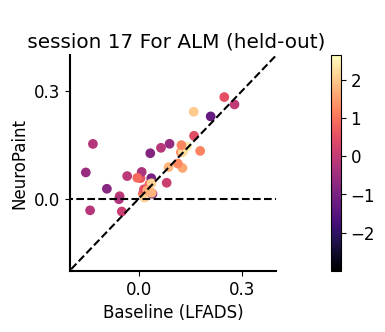

In [14]:
#for eid_ind in range(40):
for eid_ind in [9]:
    eid = heldout_info_list[eid_ind]['session_ind']

    area_ind = heldout_info_list[eid_ind]['heldout_region_ind']

    #select an area_ind that is recorded
    # recorded_area_inds = np.array(list(spike_test[eid].keys()))
    # recorded_area_inds = recorded_area_inds[recorded_area_inds != area_ind]
    # area_ind = recorded_area_inds[1] #select the first recorded area_ind

    if area_ind not in spike_test[eid].keys():
        print(eid)
        print('no area_ind in spike_test[eid]')
        continue

    spike_region_test = spike_test[eid][area_ind]
    mean_spike_number = np.mean(spike_region_test, axis=(0,1))*100 #unit Hz.


    min = -0.2
    max = 0.4

    if eid not in dfe_no_mask_pred.keys():
        print(eid)
        print('no eid in dfe_no_mask_pred')
        continue

    if area_ind not in dfe_no_mask_pred[eid].keys():
        print(eid)
        print('no area_ind in dfe_no_mask_pred')
        continue

    if dfe_no_mask_pred[eid][area_ind] is None:
        print(eid)
        print('dfe_no_mask_pred[eid][area_ind] is None')
        continue

    fig = plt.figure(figsize=(3.5,2.8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.5) 
    ax1 = plt.subplot(gs[0])
    plt.title(f'\n session {eid} For {brain_region_list[area_ind]} (held-out)')
    sc1 = ax1.scatter(dfe_lfads_pred[eid][area_ind], dfe_no_mask_pred[eid][area_ind], c=np.log(mean_spike_number), cmap='magma')
    ax1.set_xlabel('Baseline (LFADS)')
    ax1.set_ylabel('NeuroPaint')
    ax1.plot([-1,1],[-1,1], 'k--')
    ax1.plot([-1,1],[0,0], 'k--')
    ax1.set_xlim([min,max])
    ax1.set_ylim([min,max])
    ax1.set_xticks([0, max-0.1])
    ax1.set_yticks([0, max-0.1])

    # Style adjustments
    for spine in ax1.spines.values():
        spine.set_linewidth(1.5)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    cbar_ax = plt.subplot(gs[1])
    cbar = fig.colorbar(sc1, cax=cbar_ax)

#plt.savefig(figure_path + f'fig3/dfe_no_mask_pred_{eid}_{brain_region_list_acronym[area_ind]}_w_log_fr.pdf', transparent=True)


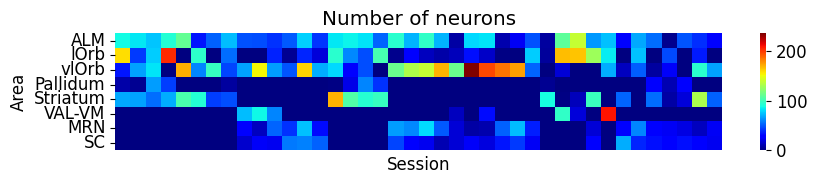

In [15]:
n_neuron_dict = {}
with torch.no_grad():
    for batch in test_dataloader:
        eid = batch['eid'][0].item()
        area_ind_list_full = batch['neuron_regions_full'][0]

        n_neuron_dict[eid] = {}

        for area_ind in areaoi_ind:
            n_neuron = torch.sum(area_ind_list_full==area_ind).item()
            n_neuron_dict[eid][area_ind] = n_neuron


n_neuron_matrix = np.zeros((len(eids), len(areaoi_ind)))

for i, eid in enumerate(eids):
    for j, area_ind in enumerate(areaoi_ind):
        if eid in n_neuron_dict.keys():
            if area_ind in n_neuron_dict[eid].keys():
                n_neuron_matrix[i,j] = n_neuron_dict[eid][area_ind]
            else:
                n_neuron_matrix[i,j] = 0
        else:
            n_neuron_matrix[i,j] = 0


plt.figure(figsize=(9,2))
sns.heatmap(n_neuron_matrix.T, cmap='jet')
plt.yticks(np.arange(len(areaoi_ind))+0.5, brain_region_list_acronym[areaoi_ind], rotation=0)
#plt.xticks(np.arange(len(eids))+0.5, eids, rotation=45)
plt.xticks([])
plt.xlabel('Session')
plt.ylabel('Area')
plt.title('Number of neurons')
plt.tight_layout()

#plt.savefig('/work/hdd/bdye/jxia4/results/figures/n_neuron_matrix_MAP_wide.pdf', transparent=True)

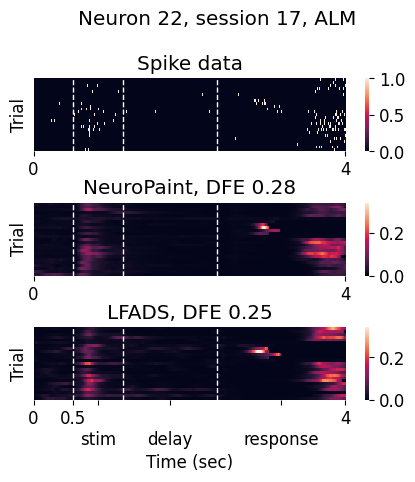

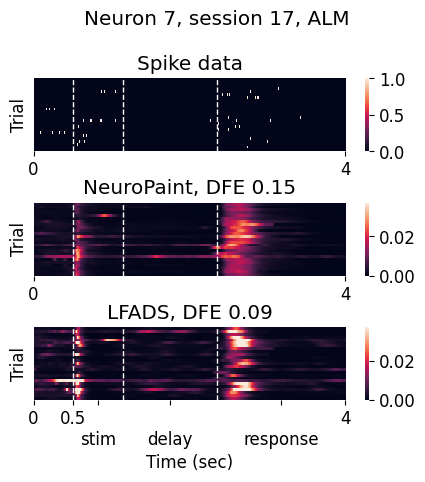

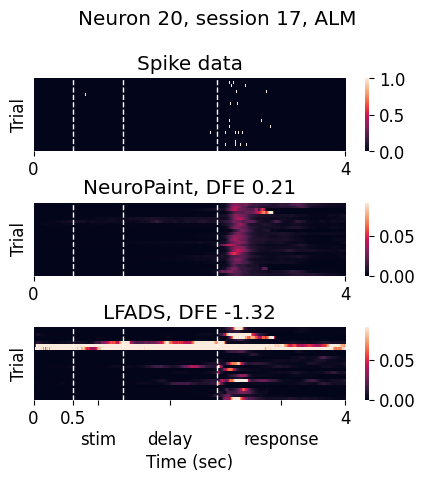

In [16]:
eid_ind = 9
area_ind = heldout_info_list[eid_ind]['heldout_region_ind']
eid = heldout_info_list[eid_ind]['session_ind']
dfe_mae = dfe_no_mask_pred[eid][area_ind]
dfe_baseline = dfe_lfads_pred[eid][area_ind]

neuron_id_sort = np.argsort(dfe_mae)[::-1]
mae_fr_pred_test = mae_no_mask_fr_pred_test[eid][area_ind]
baseline_fr_pred_test = fr_lfads_pred_test[eid][area_ind].detach().cpu().numpy()


spike_region_test = spike_test[eid][area_ind]
for i in [0, 7, 5]:
    tmp = mae_fr_pred_test[:,:,neuron_id_sort[i]]

    #sort trials based on clustering gt_
    clustering = SpectralClustering(n_clusters=4, n_neighbors=5,
                    affinity='nearest_neighbors',
                    assign_labels='discretize',
                    random_state=0)

    clustering = clustering.fit(tmp)
    trial_sort = np.argsort(clustering.labels_)
    
    plt.figure(figsize=(4.5, 4.9))
    plt.subplot(3, 1, 1)
    sns.heatmap(spike_region_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=1)
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([0,399], [0,4], rotation=0)
    plt.axvline(50, color='w', lw=1, ls='--')
    plt.axvline(115, color='w', lw=1, ls='--')
    plt.axvline(235, color='w', lw=1, ls='--')


    plt.title(f'Spike data')
    plt.subplot(3, 1, 2)
    sns.heatmap(mae_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([0,399], [0,4], rotation=0)
    plt.axvline(50, color='w', lw=1, ls='--')
    plt.axvline(115, color='w', lw=1, ls='--')
    plt.axvline(235, color='w', lw=1, ls='--')

    plt.title(f'NeuroPaint, DFE {dfe_mae[neuron_id_sort[i]]:.2f}')
    plt.subplot(3, 1, 3)
    sns.heatmap(baseline_fr_pred_test[:,:,neuron_id_sort[i]][trial_sort], vmin=0, vmax=np.max(tmp))
    plt.ylabel('Trial')
    plt.yticks([])
    plt.xticks([0, 50, 50+65/2, 115+120/2, 235+165/2,399], [0, 0.5,'\nstim', '\ndelay', '\nresponse',4], rotation=0)
    plt.xlabel('Time (sec)')
    plt.axvline(50, color='w', lw=1, ls='--')
    plt.axvline(115, color='w', lw=1, ls='--')
    plt.axvline(235, color='w', lw=1, ls='--')

    plt.title(f'LFADS, DFE {dfe_baseline[neuron_id_sort[i]]:.2f}')

    plt.suptitle(f'Neuron {neuron_id_sort[i]}, session {eid}, {brain_region_list_acronym[area_ind]}')



    plt.tight_layout()
    plt.subplots_adjust(hspace=0.7)
    #plt.savefig(f'/work/hdd/bdye/jxia4/results/figures/fig3/heldout_region_{brain_region_list_acronym[area_ind]}_session_{eid}_neuron_{neuron_id_sort[i]}_add_time.pdf', transparent=True)


In [17]:
#prepare for bar plot
dfe_mae_combine_sessions = []

dfe_mae_w_consist_wo_reg_combine_sessions = []
dfe_mae_wo_consistency_w_reg_combine_sessions = []
dfe_mae_wo_consistency_wo_reg_combine_sessions = []

dfe_lfads_combine_sessions = []
dfe_glm_combine_sessions = []
dfe_RRR_combine_sessions = []


for eid_ind in range(len(heldout_info_list)):
    eid = heldout_info_list[eid_ind]['session_ind']
    area_ind = heldout_info_list[eid_ind]['heldout_region_ind']

    #select an area_ind that is recorded
    # recorded_area_inds = np.array(list(spike_test[eid].keys()))
    # recorded_area_inds = recorded_area_inds[recorded_area_inds != area_ind]
    # for area_ind in recorded_area_inds: 
        
    if eid not in dfe_no_mask_pred.keys():
        print(eid)
        print('no eid in dfe_no_mask_pred')
        continue

    if area_ind not in dfe_no_mask_pred[eid].keys():
        print(eid)
        print('no area_ind in dfe_no_mask_pred')
        continue

    if dfe_no_mask_pred[eid][area_ind] is None:
        print(eid)
        print('dfe_no_mask_pred[eid][area_ind] is None')
        continue

    dfe_mae_combine_sessions.append(dfe_no_mask_pred[eid][area_ind])
    dfe_mae_wo_consistency_w_reg_combine_sessions.append(dfe_no_mask_pred_wo_consistency_with_reg[eid][area_ind])
    dfe_mae_wo_consistency_wo_reg_combine_sessions.append(dfe_no_mask_pred_wo_consistency_wo_reg[eid][area_ind])
    dfe_mae_w_consist_wo_reg_combine_sessions.append(dfe_no_mask_pred_no_reg[eid][area_ind])

    dfe_lfads_combine_sessions.append(dfe_lfads_pred[eid][area_ind])
    dfe_glm_combine_sessions.append(dfe_no_mask_from_record_to_heldout[eid][area_ind])
    dfe_RRR_combine_sessions.append(dfe_RRR_pred[eid][area_ind])


27
no area_ind in dfe_no_mask_pred


In [18]:
dfe_mae_combine_sessions = np.concatenate(dfe_mae_combine_sessions)
dfe_lfads_combine_sessions = np.concatenate(dfe_lfads_combine_sessions)
dfe_glm_combine_sessions = np.concatenate(dfe_glm_combine_sessions)
dfe_RRR_combine_sessions = np.concatenate(dfe_RRR_combine_sessions)
dfe_mae_w_consist_wo_reg_combine_sessions = np.concatenate(dfe_mae_w_consist_wo_reg_combine_sessions)
dfe_mae_wo_consistency_w_reg_combine_sessions = np.concatenate(dfe_mae_wo_consistency_w_reg_combine_sessions)
dfe_mae_wo_consistency_wo_reg_combine_sessions = np.concatenate(dfe_mae_wo_consistency_wo_reg_combine_sessions)


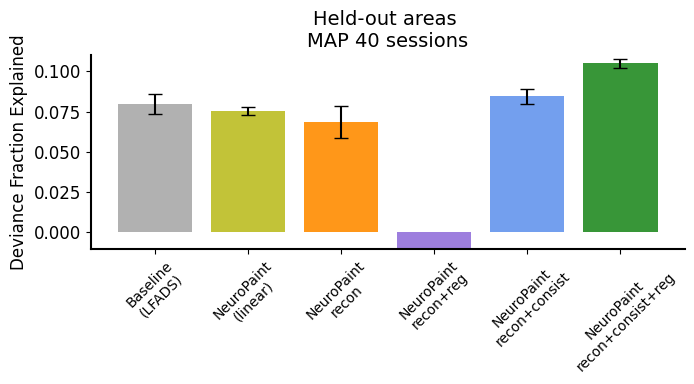

In [19]:
# Prepare data for LFADS and MAE
colors = ['darkgray', 'tab:olive', 'darkorange','mediumpurple','cornflowerblue', 'forestgreen']  # Colors for GLM, MAE, gt
methods = ['Baseline\n(LFADS)', 'NeuroPaint\n(linear)', 'NeuroPaint\nrecon','NeuroPaint\nrecon+reg', 'NeuroPaint\nrecon+consist', 'NeuroPaint\nrecon+consist+reg']  

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(dfe_lfads_combine_sessions),
    np.nanmean(dfe_RRR_combine_sessions),
    np.nanmean(dfe_mae_wo_consistency_wo_reg_combine_sessions),
    np.nanmean(dfe_mae_wo_consistency_w_reg_combine_sessions),
    np.nanmean(dfe_mae_w_consist_wo_reg_combine_sessions),
    np.nanmean(dfe_mae_combine_sessions)
]

errors = [
    np.nanstd(dfe_lfads_combine_sessions) / np.sqrt(len(dfe_lfads_combine_sessions)),
    np.nanstd(dfe_RRR_combine_sessions) / np.sqrt(len(dfe_RRR_combine_sessions)),
    np.nanstd(dfe_mae_wo_consistency_wo_reg_combine_sessions) / np.sqrt(len(dfe_mae_wo_consistency_wo_reg_combine_sessions)),
    np.nanstd(dfe_mae_wo_consistency_w_reg_combine_sessions) / np.sqrt(len(dfe_mae_wo_consistency_w_reg_combine_sessions)),
    np.nanstd(dfe_mae_w_consist_wo_reg_combine_sessions) / np.sqrt(len(dfe_mae_w_consist_wo_reg_combine_sessions)),
    np.nanstd(dfe_mae_combine_sessions) / np.sqrt(len(dfe_mae_combine_sessions))
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10, rotation=45)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
ax.set_title('Held-out areas \nMAP 40 sessions', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylim([-0.01, 0.11])
plt.tight_layout()

#plt.savefig(figure_path + f'fig3_supp_w_RRR/fig3_supp_bar_plot_dfe_heldout_40_sessions.pdf', transparent=True)

/tmp/ipykernel_1752843/4020095767.py:21: RuntimeWarning: Mean of empty slice
  np.nanmean(filtered_mae_wo_consistency_w_reg),
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


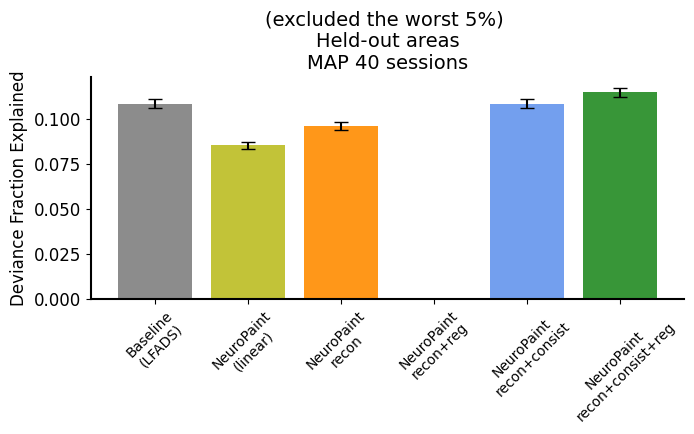

In [20]:
# Filter data to include only values greater than 0
filter_percent = 5
filtered_GLM = dfe_glm_combine_sessions[dfe_glm_combine_sessions > np.quantile(dfe_glm_combine_sessions, 0.01*filter_percent)]
filtered_mae = dfe_mae_combine_sessions[dfe_mae_combine_sessions > np.quantile(dfe_mae_combine_sessions, 0.01*filter_percent)]
filtered_mae_w_consist_wo_reg = dfe_mae_w_consist_wo_reg_combine_sessions[dfe_mae_w_consist_wo_reg_combine_sessions > np.quantile(dfe_mae_w_consist_wo_reg_combine_sessions, 0.01*filter_percent)]
filtered_mae_wo_consistency_w_reg = dfe_mae_wo_consistency_w_reg_combine_sessions[dfe_mae_wo_consistency_w_reg_combine_sessions > np.quantile(dfe_mae_wo_consistency_w_reg_combine_sessions, 0.01*filter_percent)]
filtered_mae_wo_consistency_wo_reg = dfe_mae_wo_consistency_wo_reg_combine_sessions[dfe_mae_wo_consistency_wo_reg_combine_sessions > np.quantile(dfe_mae_wo_consistency_wo_reg_combine_sessions, 0.01*filter_percent)]
filtered_lfads = dfe_lfads_combine_sessions[dfe_lfads_combine_sessions > np.quantile(dfe_lfads_combine_sessions, 0.01*filter_percent)]
filtered_RRR = dfe_RRR_combine_sessions[dfe_RRR_combine_sessions > np.quantile(dfe_RRR_combine_sessions, 0.01*filter_percent)]


# Prepare data for LFADS and MAE
colors = ['gray', 'tab:olive', 'darkorange','mediumpurple','cornflowerblue',  'forestgreen']  # Colors for GLM, MAE, gt
methods = ['Baseline\n(LFADS)', 'NeuroPaint\n(linear)', 'NeuroPaint\nrecon','NeuroPaint\nrecon+reg', 'NeuroPaint\nrecon+consist', 'NeuroPaint\nrecon+consist+reg']  

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(filtered_lfads),
    np.nanmean(filtered_RRR),
    np.nanmean(filtered_mae_wo_consistency_wo_reg),
    np.nanmean(filtered_mae_wo_consistency_w_reg),
    np.nanmean(filtered_mae_w_consist_wo_reg),
    np.nanmean(filtered_mae)
]

errors = [
    np.nanstd(filtered_lfads) / np.sqrt(len(filtered_lfads)),
    np.nanstd(filtered_RRR) / np.sqrt(len(filtered_RRR)),
    np.nanstd(filtered_mae_wo_consistency_wo_reg) / np.sqrt(len(filtered_mae_wo_consistency_wo_reg)),
    np.nanstd(filtered_mae_wo_consistency_w_reg) / np.sqrt(len(filtered_mae_wo_consistency_w_reg)),
    np.nanstd(filtered_mae_w_consist_wo_reg) / np.sqrt(len(filtered_mae_w_consist_wo_reg)),
    np.nanstd(filtered_mae) / np.sqrt(len(filtered_mae))
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(7, 4.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10, rotation = 45)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
#ax.set_title('LFADS vs MAE \n(Filtered > 5% quantile)', fontsize=14)
ax.set_title(f'(excluded the worst {filter_percent}%) \nHeld-out areas\nMAP 40 sessions', fontsize=14)

# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + f'fig2_supp_w_RRR/synthetic_dfe_barplot_with_filtered_{filter_percent}_linear_neuropaint.pdf', transparent=True)

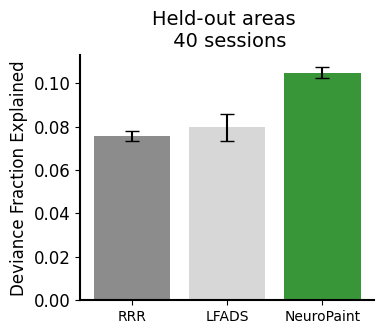

In [21]:
# Prepare data for LFADS and MAE
colors = ['gray','lightgray', 'forestgreen']  # Colors for LFADS and MAE
methods = ['RRR', 'LFADS', 'NeuroPaint']  # Only LFADS and MAE

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(dfe_RRR_combine_sessions),
    np.nanmean(dfe_lfads_combine_sessions),
    np.nanmean(dfe_mae_combine_sessions)
]

errors = [
    np.nanstd(dfe_RRR_combine_sessions) / np.sqrt(len(dfe_RRR_combine_sessions)),
    np.nanstd(dfe_lfads_combine_sessions) / np.sqrt(len(dfe_lfads_combine_sessions)),
    np.nanstd(dfe_mae_combine_sessions) / np.sqrt(len(dfe_mae_combine_sessions))
]

# Plot bar plot
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
ax.set_title('Held-out areas \n 40 sessions', fontsize=14)
#ax.set_title('Recorded areas \n 40 sessions', fontsize=14)


# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig(figure_path + 'fig3_supp_w_RRR/dfe_bar_plot_heldout_40_sessions_w_RRR.pdf', transparent=True)

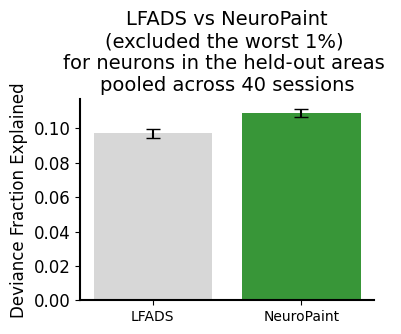

In [22]:
# Filter data to include only values greater than 0
filtered_percent = 1
filtered_lfads = dfe_lfads_combine_sessions[dfe_lfads_combine_sessions > np.quantile(dfe_lfads_combine_sessions, 0.01*filtered_percent)]
filtered_mae = dfe_mae_combine_sessions[dfe_mae_combine_sessions > np.quantile(dfe_mae_combine_sessions, 0.01*filtered_percent)]

# Prepare data for LFADS and MAE
colors = ['lightgray', 'forestgreen']  # Colors for LFADS and MAE
methods = ['LFADS', 'NeuroPaint']  # Only LFADS and MAE

# Calculate means and errors for LFADS and MAE
means = [
    np.nanmean(filtered_lfads),
    np.nanmean(filtered_mae)
]

errors = [
    np.nanstd(filtered_lfads) / np.sqrt(len(filtered_lfads)),
    np.nanstd(filtered_mae) / np.sqrt(len(filtered_mae))
]

# Prepare boxplot data
box_data = [filtered_lfads, filtered_mae]

# Plot bar plot
fig, ax = plt.subplots(figsize=(4, 3.5))
ax.bar(range(len(methods)), means, yerr=errors, color=colors, capsize=5, alpha=0.9)

# Formatting
ax.set_xticks(range(len(methods)))
ax.set_xticklabels(methods, fontsize=10)
ax.set_ylabel('Deviance Fraction Explained', fontsize=12)
#ax.set_title('LFADS vs MAE \n(Filtered > 5% quantile)', fontsize=14)
ax.set_title(f'LFADS vs NeuroPaint\n(excluded the worst {filtered_percent}%) \nfor neurons in the held-out areas \npooled across 40 sessions', fontsize=14)


# Style adjustments
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
#plt.savefig('/work/hdd/bdye/jxia4/results/figures/fig3/heldout_region_bar_plot_filtered.pdf', transparent=True)
plt.show()

In [25]:
dfe_lfads_all = []
dfe_mae_all = []
log_fr_all = []

for eid_ind in range(40):
    eid = heldout_info_list[eid_ind]['session_ind']

    area_ind = heldout_info_list[eid_ind]['heldout_region_ind']

    #select an area_ind that is recorded
    # recorded_area_inds = np.array(list(spike_test[eid].keys()))
    # recorded_area_inds = recorded_area_inds[recorded_area_inds != area_ind]
    # area_ind = recorded_area_inds[1] #select the first recorded area_ind

    if area_ind not in spike_test[eid].keys():
        print(eid)
        print('no area_ind in spike_test[eid]')
        continue

    if eid not in dfe_no_mask_pred.keys():
        print(eid)
        print('no eid in dfe_no_mask_pred')
        continue

    if area_ind not in dfe_no_mask_pred[eid].keys():
        print(eid)
        print('no area_ind in dfe_no_mask_pred')
        continue

    if dfe_no_mask_pred[eid][area_ind] is None:
        print(eid)
        print('dfe_no_mask_pred[eid][area_ind] is None')
        continue

    spike_region_test = spike_test[eid][area_ind]
    mean_spike_number = np.mean(spike_region_test, axis=(0,1))*100 #unit Hz.

    dfe_lfads_all.append(dfe_lfads_pred[eid][area_ind])
    dfe_mae_all.append(dfe_no_mask_pred[eid][area_ind])
    log_fr_all.append(np.log(mean_spike_number + 1e-12))

dfe_lfads_all = np.concatenate(dfe_lfads_all)
dfe_mae_all = np.concatenate(dfe_mae_all)
log_fr_all = np.concatenate(log_fr_all)


27
no area_ind in spike_test[eid]


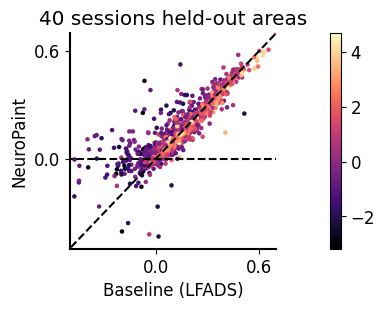

In [ ]:
fig = plt.figure(figsize=(3.5,2.8))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.05], wspace=0.5) 
ax1 = plt.subplot(gs[0])
plt.title(f'40 sessions held-out areas')
sc1 = ax1.scatter(dfe_lfads_all, dfe_mae_all, c=log_fr_all, cmap='magma', s=5)
ax1.set_xlabel('Baseline (LFADS)')
ax1.set_ylabel('NeuroPaint')
ax1.plot([-1,1],[-1,1], 'k--')
ax1.plot([-1,1],[0,0], 'k--')

min = -0.5
max = 0.7

ax1.set_xlim([min,max])
ax1.set_ylim([min,max])
ax1.set_xticks([0, max-0.1])
ax1.set_yticks([0, max-0.1])

# Style adjustments
for spine in ax1.spines.values():
    spine.set_linewidth(1.5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

cbar_ax = plt.subplot(gs[1])
cbar = fig.colorbar(sc1, cax=cbar_ax)

#plt.savefig(figure_path + f'fig3/dfe_w_log_fr_40sessions.pdf', transparent=True)
